In [1]:
import yfinance as yf
from datetime import datetime

In [2]:
import torch
print(torch.__version__)


2.1.2


In [3]:
# pharma companies used for training
pharma_list = ['BIIB', 'JNJ', 'PFE', 'ABBV']
# end time 
end = datetime.now()
start = datetime(end.year-5, end.month, end.day)

In [4]:
companies = {company : yf.download(company, start=start, end=end) for company in pharma_list}
companies

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'BIIB':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-03-27  232.940002  237.770004  227.080002  229.949997  229.949997   
 2019-03-28  230.979996  236.279999  230.110001  232.820007  232.820007   
 2019-03-29  235.589996  237.139999  233.020004  236.380005  236.380005   
 2019-04-01  239.070007  239.460007  232.220001  232.490005  232.490005   
 2019-04-02  232.350006  237.550003  232.350006  233.270004  233.270004   
 ...                ...         ...         ...         ...         ...   
 2024-03-21  219.330002  221.740005  217.949997  220.750000  220.750000   
 2024-03-22  221.300003  221.300003  215.360001  218.100006  218.100006   
 2024-03-25  217.770004  218.259995  215.589996  216.690002  216.690002   
 2024-03-26  216.149994  216.669998  211.020004  212.020004  212.020004   
 2024-03-27  213.750000  216.339996  212.919998  216.339996  216.339996   
 
              V

In [5]:
from torch import nn
import torch

In [6]:
import seaborn as sns

<Axes: xlabel='Date', ylabel='Adj Close'>

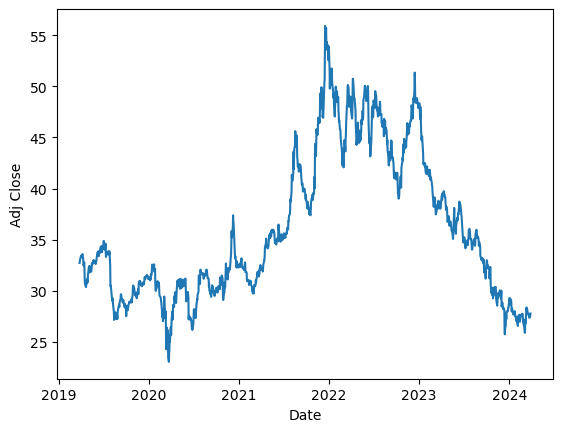

In [7]:
pfe = companies["PFE"]["Adj Close"]
sns.lineplot(data=pfe)

In [8]:
def robust_scale(data: torch.Tensor, axis: int = 0):
	IQR3 = torch.quantile(data, 0.75, dim=axis, keepdims=True)
	IQR1 = torch.quantile(data, 0.25, dim=axis, keepdims=True)
	return (data - torch.median(data)) / (IQR3 - IQR1)

In [9]:
# scale the data
scaled = robust_scale(torch.tensor(pfe.values).float())

In [10]:
train_size = int(0.8 * len(scaled))
train_data, test_data = torch.split(scaled, [train_size, len(scaled) - train_size])

window_size = 60
# time window
train_x = train_data.unfold(0, window_size, 1)

# actual resulte
train_y = train_data[window_size:]

In [11]:
#A simple demo for LSTM for stock prediction 


class StockLSTM(nn.Module):
	def __init__(self, device='cpu'):
		super(StockLSTM, self).__init__()
		# utilizing 3 layers of LSTM
		self.lstms = nn.ModuleList([
            nn.LSTM(128, hidden_size=64, batch_first=True),
            nn.LSTM(64, hidden_size=32, batch_first=True),
            nn.LSTM(32, hidden_size=16, batch_first=True)  # Ensure consistency in input_size
        ])
		self.dropouts = nn.ModuleList([nn.Dropout(0.5) for _ in range(2)])

		self.device = device
		self.linear = nn.Linear(16, 1)
		self.to(device)
		
	
	def forward(self,x):
		
		# since we would only need the last output of the LSTM
		
		x = x.to(self.device)
		for i in range(len(self.lstms)):
			x, _ = self.lstms[i](x)
			# apply residual connection
			if i < len(self.dropouts):
				x = self.dropouts[i](x)
		x = x[ -1, :]
		x = self.linear(x)
		
		return x
	# torch.to for moving the tensor to the device

	
	def train_loop(self, train_x, train_y, val_x, val_y):
		# chooses gpu if available, otherwise cpu
		
		# chose the adam optimizer for the gradient descent
		train_x, train_y = train_x.to(self.device), train_y.to(self.device)
		val_x, val_y = val_x.to(self.device), val_y.to(self.device)
		optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
		# currently using MSE loss function to fit the model ()
		loss_fn = nn.MSELoss()

		# training the model for 100 epochs
		for epoch in range(100):
			# set to training mode
			self.train()

			# zero the gradients otherwise they would accumulate
			optimizer.zero_grad()
			pred = self(train_x)
			loss = loss_fn(pred, train_y)
			loss.backward()
			optimizer.step()


			# set to evaluation mode
			self.eval()
			with torch.no_grad():  # Inference mode, gradients not computed
				val_pred = self(val_x)
				val_loss = loss_fn(val_pred, val_y)
			
			print(f'Epoch {epoch} loss: {loss.item()}', f'Validation loss: {val_loss.item()}')

	def test_loss(self, test_x, test_y):
		self.eval()
		with torch.no_grad():
			pred = self(test_x)
			loss_fn = nn.MSELoss()
			loss = loss_fn(pred, test_y)
			print(f'Test loss: {loss.item()}')


In [12]:
model = StockLSTM(device='cpu')
model.train_loop(train_x, train_y, train_x, train_y)


# test the model
test_x = test_data.unfold(0, window_size, 1)
test_y = test_data[window_size:]
# set to evaluation mode
model.eval()

c:\Users\JoyChang\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([948])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 0.6703745722770691 Validation loss: 0.47950479388237
Epoch 1 loss: 0.4969143569469452 Validation loss: 0.48215487599372864
Epoch 2 loss: 0.4826911687850952 Validation loss: 0.46563753485679626
Epoch 3 loss: 0.45282211899757385 Validation loss: 0.45921748876571655
Epoch 4 loss: 0.4592958092689514 Validation loss: 0.4527343809604645
Epoch 5 loss: 0.45276907086372375 Validation loss: 0.45627668499946594
Epoch 6 loss: 0.4567588269710541 Validation loss: 0.455787718296051
Epoch 7 loss: 0.45926132798194885 Validation loss: 0.45300960540771484
Epoch 8 loss: 0.45280495285987854 Validation loss: 0.45285099744796753
Epoch 9 loss: 0.4587000906467438 Validation loss: 0.4527563452720642
Epoch 10 loss: 0.45285218954086304 Validation loss: 0.4527433514595032
Epoch 11 loss: 0.45659396052360535 Validation loss: 0.4530044198036194
Epoch 12 loss: 0.45695263147354126 Validation loss: 0.4530507028102875
Epoch 13 loss: 0.4527376592159271 Validation loss: 0.45312923192977905
Epoch 14 loss: 0.45

StockLSTM(
  (lstms): ModuleList(
    (0): LSTM(128, 64, batch_first=True)
    (1): LSTM(64, 32, batch_first=True)
    (2): LSTM(32, 16, batch_first=True)
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.5, inplace=False)
  )
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
model.test_loss(test_x, test_y)

Test loss: 0.35699209570884705


c:\Users\JoyChang\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
